<a href="https://colab.research.google.com/github/nferencesinghv04/MaskRcnn/blob/main/faster_rcnn_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [ ]:
"""
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)
"""

device= torch.device("cpu")


<h1 id="Read-a-batch-of-training-images-along-with-their-bounding-boxes-and-lables.">Read a batch of training images along with their bounding boxes and lables.<a class="anchor-link" href="#Read-a-batch-of-training-images-along-with-their-bounding-boxes-and-lables.">¶</a></h1><p>In this example, I use read only 1 image, i.e., batch_size=1</p>


(661, 1055, 3)


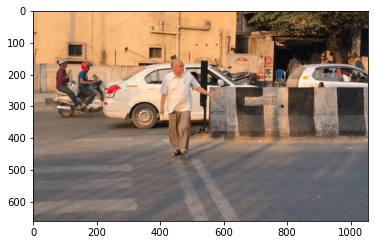

In [ ]:
# input image could be of any size
img0 = cv2.imread('test.png')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
print(img0.shape)
plt.imshow(img0)
plt.show()

In [ ]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
bbox0 = np.array([[144, 384, 144+329, 384+204], [149, 66, 149+163, 66+70]]) 
labels = np.array([1, 1]) # 0: background, 1: person

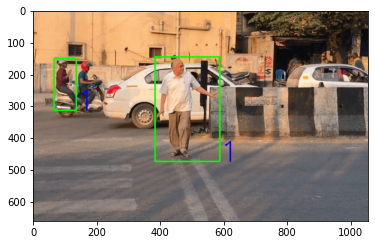

In [ ]:

# display bounding box and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()    




<h1 id="Resize-the-input-images-to-(h=800,-w=800)">Resize the input images to (h=800, w=800)<a class="anchor-link" href="#Resize-the-input-images-to-(h=800,-w=800)">¶</a></h1>


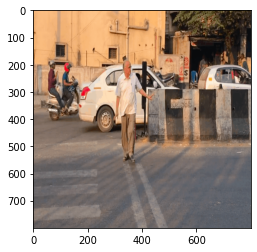

In [ ]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [ ]:
# change the bounding box coordinates 
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[174 291 572 445]
 [180  50 377 103]]


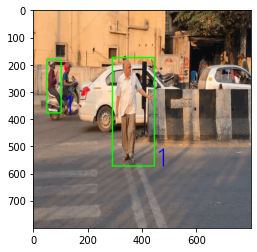

In [ ]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()    


<h1 id="Use-VGG16-to-extract-features-from-input-images">Use VGG16 to extract features from input images<a class="anchor-link" href="#Use-VGG16-to-extract-features-from-input-images">¶</a></h1><h2 id="Input-images-(batch_size,-H=800,-W=800,-d=3),--Features:-(batch_size,-H=-50,-W=50,-d=512)">Input images (batch_size, H=800, W=800, d=3),  Features: (batch_size, H= 50, W=50, d=512)<a class="anchor-link" href="#Input-images-(batch_size,-H=800,-W=800,-d=3),--Features:-(batch_size,-H=-50,-W=50,-d=512)">¶</a></h2>


In [ ]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [ ]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

torch.Size([1, 3, 800, 800])
30
512


In [ ]:
req_features

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [ ]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
faster_rcnn_fe_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:

# applying transform to input image before passing into feature extractor 
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


In [ ]:
imgTensor.shape

torch.Size([1, 3, 800, 800])

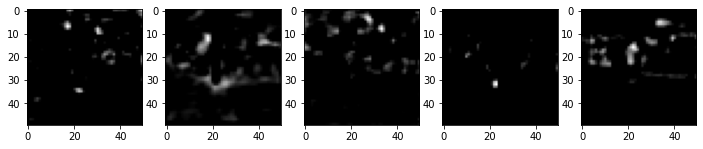

In [ ]:

# visualize the first 5 channels of the 50*50*512 feature maps
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()




<h1 id="Generate-22,500-anchor-boxes-on-each-input-image">Generate 22,500 anchor boxes on each input image<a class="anchor-link" href="#Generate-22,500-anchor-boxes-on-each-input-image">¶</a></h1><p>50x50=2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9=22,500</p>


In [ ]:
# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
fe_size

50

In [ ]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


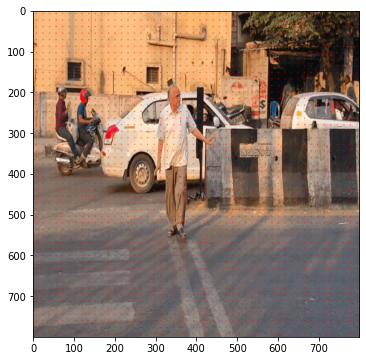

In [ ]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_clone)
plt.show()  

In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


In [ ]:
print(fe_size)
print(img.shape)
print(bbox)

50
(800, 800, 3)
[[174 291 572 445]
 [180  50 377 103]]


In [ ]:
(50+103)/2

76.5

In [ ]:
76*9

684

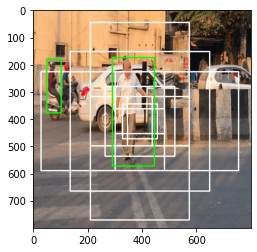

In [ ]:
# display the 9 anchor boxes of one anchor and the ground truth bbox
img_clone = np.copy(img)
for i in range(11025, 11034):  #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show() 


## valid-anchor-boxes ground-truth-bboxes iou

In [ ]:

# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [ ]:
# Calculate iou of the valid anchor boxes 
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)



(8940, 2)


In [ ]:
ious[0]

array([0.        , 0.02851431], dtype=float32)

In [ ]:
# What anchor box has max iou with the ground truth bbox  
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

[3782   63]


In [ ]:
gt_argmax_ious
print(ious[3782])
print(ious[63])

[0.7844489 0.       ]
[0.        0.5567894]


In [ ]:
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[0.7844489 0.5567894]


In [ ]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[  63  143 3782 3789 4040 4048]


In [ ]:
for i in range(0,len(gt_argmax_ious)):
    print(ious[gt_argmax_ious[i]])

[0.        0.5567894]
[0.        0.5567894]
[0.7844489 0.       ]
[0.7844489 0.       ]
[0.7844489 0.       ]
[0.7844489 0.       ]


In [ ]:
# What ground truth bbox is associated with each anchor box 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)

(8940,)


In [ ]:
print(argmax_ious)

[1 1 1 ... 0 0 0]


In [ ]:
ious[0:5]# we can see second object has more

array([[0.        , 0.02851431],
       [0.        , 0.06190387],
       [0.        , 0.09753407],
       [0.        , 0.1356383 ],
       [0.        , 0.17648348]], dtype=float32)

In [ ]:
print(len(index_inside))
print(index_inside)

8940
[ 1410  1419  1428 ... 21075 21084 21093]


In [ ]:
max_ious.shape

(8940,)

In [ ]:
print(np.arange(len(index_inside)))
print(argmax_ious)

[   0    1    2 ... 8937 8938 8939]
[1 1 1 ... 0 0 0]


In [ ]:
ious[0][1]

0.028514313

* It basically gives data for all 8940 valid anchors. It takes all valid anchor boxes and extract the ious of that
object which has max ious, in this case its 2 objects, so max of the two. And it stores that iou in the max ious

In [ ]:
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

[0.02851431 0.06190387 0.09753407 ... 0.         0.         0.        ]



## valid-anchor-boxes

* -1:-object
* -0:-background
* -1:-ignore

In [ ]:
# 8940 valid anchor boxes : -1 (ignore)
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [ ]:
# Use iou to assign 1 (objects) to two kind of anchors 
# a) The anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

## mini-batch training 
- Select 256 valid anchor boxes which will be our RPN
- Out of 256, 128 will be positive examples and other 128 will be negative examples
- We will ignore the labels with value -1

In [ ]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [ ]:
print(len(pos_index))
print(len(neg_index))

32
96


In [ ]:
len(label)

8940

In [ ]:
label

array([ 0, -1, -1, ..., -1, -1, -1], dtype=int32)

### Bundle valid anchor boxes of format (y1,x1,y2,x2) and turn them into loc=(cy-cya/ha),(cx-cxa/wa),log(h/ha),log(w/wa)
* In order to train RPN learn anchor-box relative-ground-truth-box difference-

In [ ]:
# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

(8940, 4)


In [ ]:
max_iou_bbox[0]

array([180,  50, 377, 103])

In [ ]:
# valid anchor boxes OF h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

print(valid_anchor_boxes[0])
print(height[0],width[0],ctr_y[0],ctr_x[0])

[ 13.49033201  10.745166   194.50966799 101.254834  ]
181.01933598375615 90.50966799187808 103.99999999999999 55.99999999999999


In [ ]:
# valid anchor box of max iou bbox  h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

print(max_iou_bbox[0])
print(base_height[0],base_width[0],base_ctr_x[0],base_ctr_y[0])

[180  50 377 103]
197 53 76.5 278.5


In [ ]:
# valid anchor boxes of loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #let height !=0, minimum is eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)


In [ ]:
print(eps,height[0],width[0])
print(dy[0],dx[0],dh[0],dw[0])
anchor_locs[0]

2.220446049250313e-16 181.01933598375615 90.50966799187808
0.9639854165394731 0.2264951408488161 0.08459987453839882 -0.5351647600875226


array([ 0.96398542,  0.22649514,  0.08459987, -0.53516476])

In [ ]:
len(anchor_locs)

8940

### First put label=-1 22500 anchor-boxes and then fill in locations and labels of 8940 valid anchor boxes 

In [ ]:
print(label)
print(len(label))

[ 0 -1 -1 ... -1 -1 -1]
8940


In [ ]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

(22500,)


In [ ]:
anchor_boxes.shape[1:]

(4,)

In [ ]:
len(anchor_boxes)

22500

In [ ]:
anchor_boxes.shape[1:]

(4,)

In [ ]:
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500, 4)


### Send the features- of the input image to RPN, -prediction 22500 region proposals(ROIs)

In [ ]:

in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
print(out_map.shape)
x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
print(x.shape)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(out_map.shape,pred_anchor_locs.shape, pred_cls_scores.shape)



torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50]) torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


### Convert RPN to predict the position and classification of the anchor box format


In [ ]:
# Location: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2]  (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)


torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


### Calculate RPN loss based on 22500 ROIs predicted by RPN and 22500 anchor boxes

In [ ]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6937, grad_fn=<NllLossBackward>)


In [ ]:
# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([12, 4]) torch.Size([12, 4])
tensor(0.4732, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)


tensor(1.0881, dtype=torch.float64, grad_fn=<AddBackward0>)


## Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications

### First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

In [ ]:
#First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# The labelled 22500 anchor boxes 
# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_height.shape, anc_width.shape, anc_ctr_x.shape, anc_ctr_y.shape)

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] # dy of each anchor box
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(pred_anchor_locs_numpy.shape, objectness_score_numpy.shape, dy.shape, dx.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,) (22500,) (22500,) (22500,)
(22500, 4) (22500,) (22500, 1) (22500, 1)
(22500, 1)


In [ ]:
# Use labeled anchor boxes and RPN predicted anchor boxes to calculate ROI = [y1, x1, y2, x2]
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

(22500, 4)


In [ ]:
roi

array([[ -40.52169793,  -76.94138888,   52.414528  ,  102.61022794],
       [ -82.53669592, -181.13842025,   86.02283939,  200.3949319 ],
       [-184.88918058, -388.59195583,  173.44674037,  330.45704924],
       ...,
       [ 704.83045256,  748.18308051,  883.93474364,  838.22843454],
       [ 610.32132175,  700.98004351,  963.55751988,  880.99968052],
       [ 425.46911686,  598.5739468 , 1158.84622698,  956.60378856]])

In [ ]:
roi[:, slice(0, 4, 2)] # getting y

array([[ -40.52169793,   52.414528  ],
       [ -82.53669592,   86.02283939],
       [-184.88918058,  173.44674037],
       ...,
       [ 704.83045256,  883.93474364],
       [ 610.32132175,  963.55751988],
       [ 425.46911686, 1158.84622698]])

In [ ]:
roi[:, slice(1, 4, 2)] # getting x

array([[ -76.94138888,  102.61022794],
       [-181.13842025,  200.3949319 ],
       [-388.59195583,  330.45704924],
       ...,
       [ 748.18308051,  838.22843454],
       [ 700.98004351,  880.99968052],
       [ 598.5739468 ,  956.60378856]])

In [ ]:
# clip the predicted boxes to the image
#ROI = [y1, x1, y2, x2]
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [ ]:
# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(12000,) (12000, 4) (12000,)


In [ ]:
score.ravel()

array([-0.01860826,  0.04115162, -0.04428146, ...,  0.02112499,
        0.00222667, -0.00183325], dtype=float32)

In [ ]:
score.ravel().argsort() #returns indexes that will sort the array

array([6665, 6215, 6224, ..., 7109, 7172, 6722])

In [ ]:
# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(12000,)
(12000,) (12000, 4) (12000, 4)


In [ ]:
# Take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# Find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
len(order)

12000

In [ ]:
order

array([6722, 7172, 7109, ..., 6224, 6215, 6665])

In [ ]:
order.argsort() #basically applying argsort in ascending order

array([7577, 2292, 9540, ..., 7405, 9021, 5168])

In [ ]:
order.argsort()[::-1] #basically applying argsort in descending order

array([5168, 9021, 7405, ..., 9540, 2292, 7577])

array([ 16.20106844,   0.        ,  70.64273423, ..., 658.09927163,
       646.82163125, 462.62482242])

In [ ]:
#Take the indexes of order the probability score in descending order 
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the 1st element in order and append to keep 
    keep.append(i)
    #here x1, y1, x2 and y2 are co-ordinates of the roi
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


In [ ]:
roi.shape

(2000, 4)

## For the 2000 ROIs screened out by NMS, calculate the iou value of the gt box, and screen out 128 ROI samples, of which the maximum number of positives is 128x0.25=32

In [ ]:
n_sample = 128  # Number of samples from roi 
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.25  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.25  # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# Find the iou of each ground truth object with the region proposals, 
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [ ]:
ious[550]

array([0.15307942, 0.        ], dtype=float32)

In [ ]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = ious.argmax(axis=1) #ground truth has high IoU
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 0 0 ... 0 0 0]
[0.         0.         0.         ... 0.21250069 0.         0.09356188]


In [ ]:
gt_assignment.shape

(2000,)

In [ ]:
# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 1 1 ... 1 1 1]


In [ ]:
# Select the foreground rois as per the pos_iou_thesh and 
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)



32
[  63 1866 1996 1174 1471 1246  832 1355 1893 1493 1413 1329 1613 1895
 1396  850  265 1746  380 1069  948 1260  396 1869  557  570 1947 1989
 1387   90 1732  969]
96
[ 159 1498 1031  574  222  967 1415  382 1991 1599  417  664 1218 1850
  589 1341 1791 1510  395 1181  692  312  365  512    1 1421 1685  376
  269  562  740  709  425 1662 1858 1619  825 1161   67 1978  316  607
 1372   93  354 1683  874 1776 1652  150  921 1192  889  411  477  600
  530  390  344  587  979 1940 1024 1785 1734  389  822 1340 1497 1723
 1977 1472 1809  249 1955  725   62 1788 1205  433 1707 1093  774  461
  892 1408    0 1551 1855  925  986 1486 1317  275  181  465]


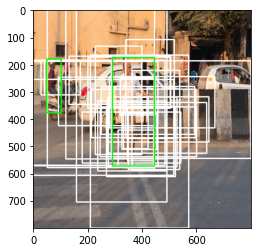

In [ ]:
# display ROI samples with postive 
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

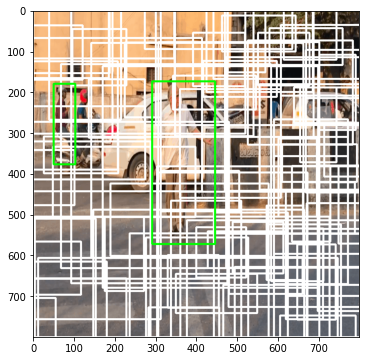

In [ ]:
# display ROI samples with negative 
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

In [ ]:
# Now we gather positve samples index and negitive samples index, 
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [ ]:
sample_roi[120]

array([645.8091171 , 349.1338897 , 741.73958463, 548.77248144])

In [ ]:
bbox_for_sampled_roi[120]

array([174, 291, 572, 445])

In [ ]:
eps

2.220446049250313e-16

In [ ]:
np.finfo(height.dtype).eps

2.220446049250313e-16

In [ ]:
np.finfo(height.dtype).eps

2.220446049250313e-16

In [ ]:
height[0]

383.63097855044407

In [ ]:
height = np.maximum(height, eps)

In [ ]:
height[0]

383.63097855044407

In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [ ]:
np.vstack((dy[0], dx[0], dh[0], dw[0]))

array([[-0.01823702],
       [ 0.30195252],
       [ 0.03677091],
       [-1.09183621]])

In [ ]:
np.vstack((dy[0], dx[0], dh[0], dw[0])).transpose()

array([[-0.01823702,  0.30195252,  0.03677091, -1.09183621]])

In [ ]:
gt_roi_locs[0]

array([-0.01823702,  0.30195252,  0.03677091, -1.09183621])

## Take out the features of 128 ROI samples, use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

In [ ]:

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)



torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [ ]:

size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])



In [ ]:
out_map.shape

torch.Size([1, 512, 50, 50])

In [ ]:
rois.shape

torch.Size([128, 5])

In [ ]:
rois[0].shape

torch.Size([5])

In [ ]:
rois.size(0)

128

In [ ]:
for i in range(0,128):
    if rois[i][0]!=0:
        print(i,rois[i])
        break

In [ ]:

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
print(len(output))
print(output[0].shape)
output = torch.cat(output, 0)
print(output.size())



128
torch.Size([1, 512, 7, 7])
torch.Size([128, 512, 7, 7])


In [ ]:
out_map.narrow(0, im_idx, 1).shape

torch.Size([1, 512, 50, 50])

In [ ]:
im.shape

torch.Size([1, 512, 9, 9])

In [ ]:
tmp.shape

(7, 7)

In [ ]:
output.shape

torch.Size([128, 512, 7, 7])

(25, 29)
(14, 7)
(12, 24)
(24, 12)
(9, 9)


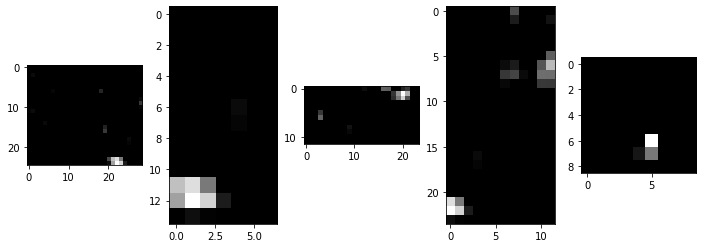

In [ ]:

# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    print(tmp.shape)
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()



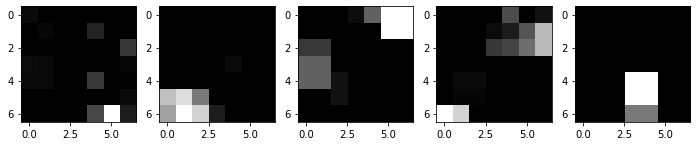

In [ ]:

# Visualize the first 5 ROI's feature maps after ROI pooling (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()



In [ ]:

# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512



torch.Size([128, 25088])


## 128 boxes + features (7x7x512) of ROI samples sent to Detection network to predict the bounding box and class of the input image

In [ ]:

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # (1 class (in this case) + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # (1 classes,+ 1 background)

In [ ]:
roi_head_classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): Linear(in_features=4096, out_features=4096, bias=True)
)

In [ ]:

# passing the output of roi-pooling to ROI head 
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)



torch.Size([128, 8]) torch.Size([128, 2])


## Calculate the loss of Fast RCNN according to the gt bboxes and features (h, w, d=512) corresponding to these 128 ROIs

In [ ]:

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)



torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:

gt_roi_labels



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)



torch.Size([128, 4]) torch.Size([128])


In [ ]:
roi_cls_loss

tensor(0.7037, grad_fn=<NllLossBackward>)

In [ ]:
torch.arange(0, n_sample).long()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127])

In [ ]:
gt_roi_label

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

# Regression loss
n_sample = roi_cls_loc.shape[0]
print(n_sample)
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())



128
torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([32, 4]) torch.Size([32, 4])
tensor(22.7358, dtype=torch.float64, grad_fn=<SumBackward0>)


## testing exactly how the regression loss is calculated between 128,2,4 and 18,4

In [ ]:
t1 = torch.rand(5,2,4)
print(t1)

tensor([[[0.9418, 0.1014, 0.7305, 0.6795],
         [0.5410, 0.6673, 0.6593, 0.6713]],

        [[0.2907, 0.0439, 0.9382, 0.7140],
         [0.0077, 0.0488, 0.9576, 0.2924]],

        [[0.2719, 0.2462, 0.8620, 0.2632],
         [0.3671, 0.6045, 0.6472, 0.7153]],

        [[0.8419, 0.5841, 0.6821, 0.8587],
         [0.9970, 0.8742, 0.4708, 0.7462]],

        [[0.8507, 0.7900, 0.1944, 0.9718],
         [0.2269, 0.7211, 0.8826, 0.9164]]])


In [ ]:
t2 = torch.randint(2,(5,1)).view(-1)

In [ ]:
t1[torch.arange(0, 5).long(), t2]

tensor([[0.5410, 0.6673, 0.6593, 0.6713],
        [0.2907, 0.0439, 0.9382, 0.7140],
        [0.3671, 0.6045, 0.6472, 0.7153],
        [0.8419, 0.5841, 0.6821, 0.8587],
        [0.8507, 0.7900, 0.1944, 0.9718]])

In [ ]:
roi_loc[1]

tensor([ 0.0418,  0.0548, -0.0640, -0.1260], grad_fn=<SelectBackward>)

## APPROXIMATE JOINT TRAINING AS PER RESEARCH PAPER REDUCES TIME BY ABOUT 25-50%

## combining loss

In [ ]:

roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)



tensor([[0.7322, 1.4236, 2.0320, 6.7996],
        [2.3506, 1.3572, 3.3401, 2.4675],
        [1.2531, 1.0018, 6.1140, 3.2625],
        [1.0388, 1.3935, 1.2032, 0.7076],
        [2.9320, 0.7425, 5.4635, 1.0747],
        [0.9234, 0.7075, 8.4813, 5.9083],
        [0.7057, 1.1379, 7.4927, 3.1941],
        [0.8812, 0.7450, 6.2415, 4.2396],
        [0.7823, 1.9334, 1.9736, 6.0764],
        [2.2319, 1.3025, 3.1978, 2.6092],
        [0.7676, 1.4521, 0.9805, 0.7443],
        [0.8656, 0.7119, 4.5164, 2.5175],
        [1.6965, 0.7821, 3.8257, 2.4985],
        [7.5617, 0.7060, 7.7914, 0.9046],
        [0.7380, 0.8560, 3.3599, 5.0933],
        [0.7419, 1.0607, 0.8431, 0.7102],
        [0.7127, 2.0463, 0.7736, 3.2206],
        [0.8795, 0.7038, 2.5018, 5.6735],
        [1.3800, 0.7336, 3.6602, 2.7111],
        [1.4428, 0.9797, 5.9053, 3.0503],
        [0.7067, 1.3852, 5.3202, 2.3083],
        [0.7232, 0.8996, 1.6385, 1.8871],
        [1.5101, 0.7426, 2.5607, 1.9534],
        [0.7706, 0.7043, 8.7611, 5

In [ ]:

total_loss = rpn_loss + roi_loss
print(len(total_loss))

print(total_loss)




32
tensor([[ 1.8203,  2.5117,  3.1201,  7.8877],
        [ 3.4387,  2.4453,  4.4282,  3.5556],
        [ 2.3412,  2.0899,  7.2021,  4.3506],
        [ 2.1269,  2.4816,  2.2913,  1.7957],
        [ 4.0201,  1.8306,  6.5516,  2.1628],
        [ 2.0115,  1.7955,  9.5694,  6.9963],
        [ 1.7938,  2.2260,  8.5808,  4.2821],
        [ 1.9693,  1.8331,  7.3296,  5.3277],
        [ 1.8704,  3.0215,  3.0616,  7.1645],
        [ 3.3199,  2.3906,  4.2859,  3.6973],
        [ 1.8557,  2.5402,  2.0686,  1.8324],
        [ 1.9537,  1.8000,  5.6045,  3.6056],
        [ 2.7846,  1.8702,  4.9138,  3.5866],
        [ 8.6497,  1.7941,  8.8795,  1.9927],
        [ 1.8261,  1.9441,  4.4480,  6.1814],
        [ 1.8300,  2.1488,  1.9312,  1.7983],
        [ 1.8008,  3.1344,  1.8617,  4.3087],
        [ 1.9676,  1.7918,  3.5899,  6.7616],
        [ 2.4681,  1.8217,  4.7483,  3.7992],
        [ 2.5309,  2.0678,  6.9934,  4.1384],
        [ 1.7948,  2.4732,  6.4083,  3.3964],
        [ 1.8113,  1.9877,  2.7